In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

from astrodet import astrodet as toolkit
from astrodet.detectron import get_astro_dicts_temp, get_astro_dicts, read_image, plot_stretch_Q

In [2]:
# Print the versions to test the imports and so we know what works
print(detectron2.__version__)
print(np.__version__)
print(cv2.__version__)

0.3
1.19.2
3.4.10


### Register HSC training data

The file metadata for each dataset is specified with the `filesnames_dict`. We will specify the filters first, then populate the filenames in the dataset directory.

For a custom dataset, this dictionary needs to be populated correctly for your data.

In [3]:
dirpath = '/home/shared/hsc' # Path to dataset

In [4]:
from detectron2.structures import BoxMode
from astropy.io import fits
import glob
dataset_names = ['train', 'test']#,'val']

filenames_dict_list = [] # List holding filenames_dict for each dataset

for i, d in enumerate(dataset_names):
    
    data_path = os.path.join(dirpath, d)

    # Get dataset dict info
    filenames_dict = {}
    filenames_dict['filters'] = ['g', 'r', 'i']

    # Get each unqiue tract-patch in the data directory
    files = glob.glob(os.path.join(data_path, '*_scarlet_segmask.fits'))
    s = [os.path.basename(f).split('_scarlet_segmask.fits')[0] for f in files]
    print(f'Tract-patch List: {s}')

    for f in filenames_dict['filters']:
        filenames_dict[f] = {}
        # List of image files in the dataset
        #Yufeng dec/21  [Errno 2] No such file or directory: '/home/shared/hsc/test/G-I-8525-4,5-c5_scarlet_img'
        #filenames_dict[f]['img'] = [os.path.join(data_path, f'{f.upper()}-{tract_patch}_scarlet_img.fits') for tract_patch in s]
        filenames_dict[f]['img'] = [os.path.join(data_path, f'{tract_patch}_scarlet_img.fits') for tract_patch in s]
        # List of mask files in the dataset
        filenames_dict[f]['mask'] = [os.path.join(data_path, f'{tract_patch}_scarlet_segmask.fits') for tract_patch in s]
        
    filenames_dict_list.append(filenames_dict)

Tract-patch List: []
Tract-patch List: ['I-8525-4,5-c5', 'I-9814-5,6-c4', 'I-8525-4,5-c0', 'I-8525-4,5-c12', 'I-9463-1,3-c3', 'I-9571-2,8-c0', 'I-9814-5,6-c3', 'I-9463-1,3-c2', 'I-9571-2,8-c15', 'I-9814-5,6-c6', 'I-9814-5,6-c13', 'I-9571-2,8-c12', 'I-9812-2,2-c3', 'I-9571-2,8-c7', 'I-9571-2,8-c1', 'I-9814-5,6-c0', 'I-9814-5,6-c7', 'I-9571-2,8-c4', 'I-9571-2,8-c10', 'I-8525-4,5-c14', 'I-9812-2,2-c4', 'I-9571-2,8-c14', 'I-9571-2,8-c6', 'I-9571-2,8-c8', 'I-8525-4,5-c15', 'I-8525-4,5-c3', 'I-9814-5,6-c2', 'I-8525-4,5-c2', 'I-9463-1,3-c0', 'I-9571-2,8-c2', 'I-8525-4,5-c9', 'I-8525-4,5-c7', 'I-9571-2,8-c3', 'I-8525-4,5-c11', 'I-8525-4,5-c4', 'I-9812-2,2-c0', 'I-9812-2,2-c2', 'I-9812-2,2-c1', 'I-9814-5,6-c11', 'I-8525-4,5-c1', 'I-9814-5,6-c10', 'I-9814-5,6-c14', 'I-9571-2,8-c13', 'I-9814-5,6-c8', 'I-8525-4,5-c13', 'I-9571-2,8-c5', 'I-9814-5,6-c5', 'I-9814-5,6-c12', 'I-8525-4,5-c6', 'I-8525-4,5-c8', 'I-9814-5,6-c15', 'I-9571-2,8-c9', 'I-9814-5,6-c9', 'I-9571-2,8-c11', 'I-8525-4,5-c10', 'I-9463

Now, we register the dataset following the detectron2 documention.

In [5]:
#Yufeng jan8 use get_astro_dicts_temp for now
for i, d in enumerate(dataset_names):
    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts_temp(filenames_dict))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"])
astro_train_metadata = MetadataCatalog.get("astro_train")
astro_test_metadata = MetadataCatalog.get("astro_test")

### Visualize ground truth examples

uint8


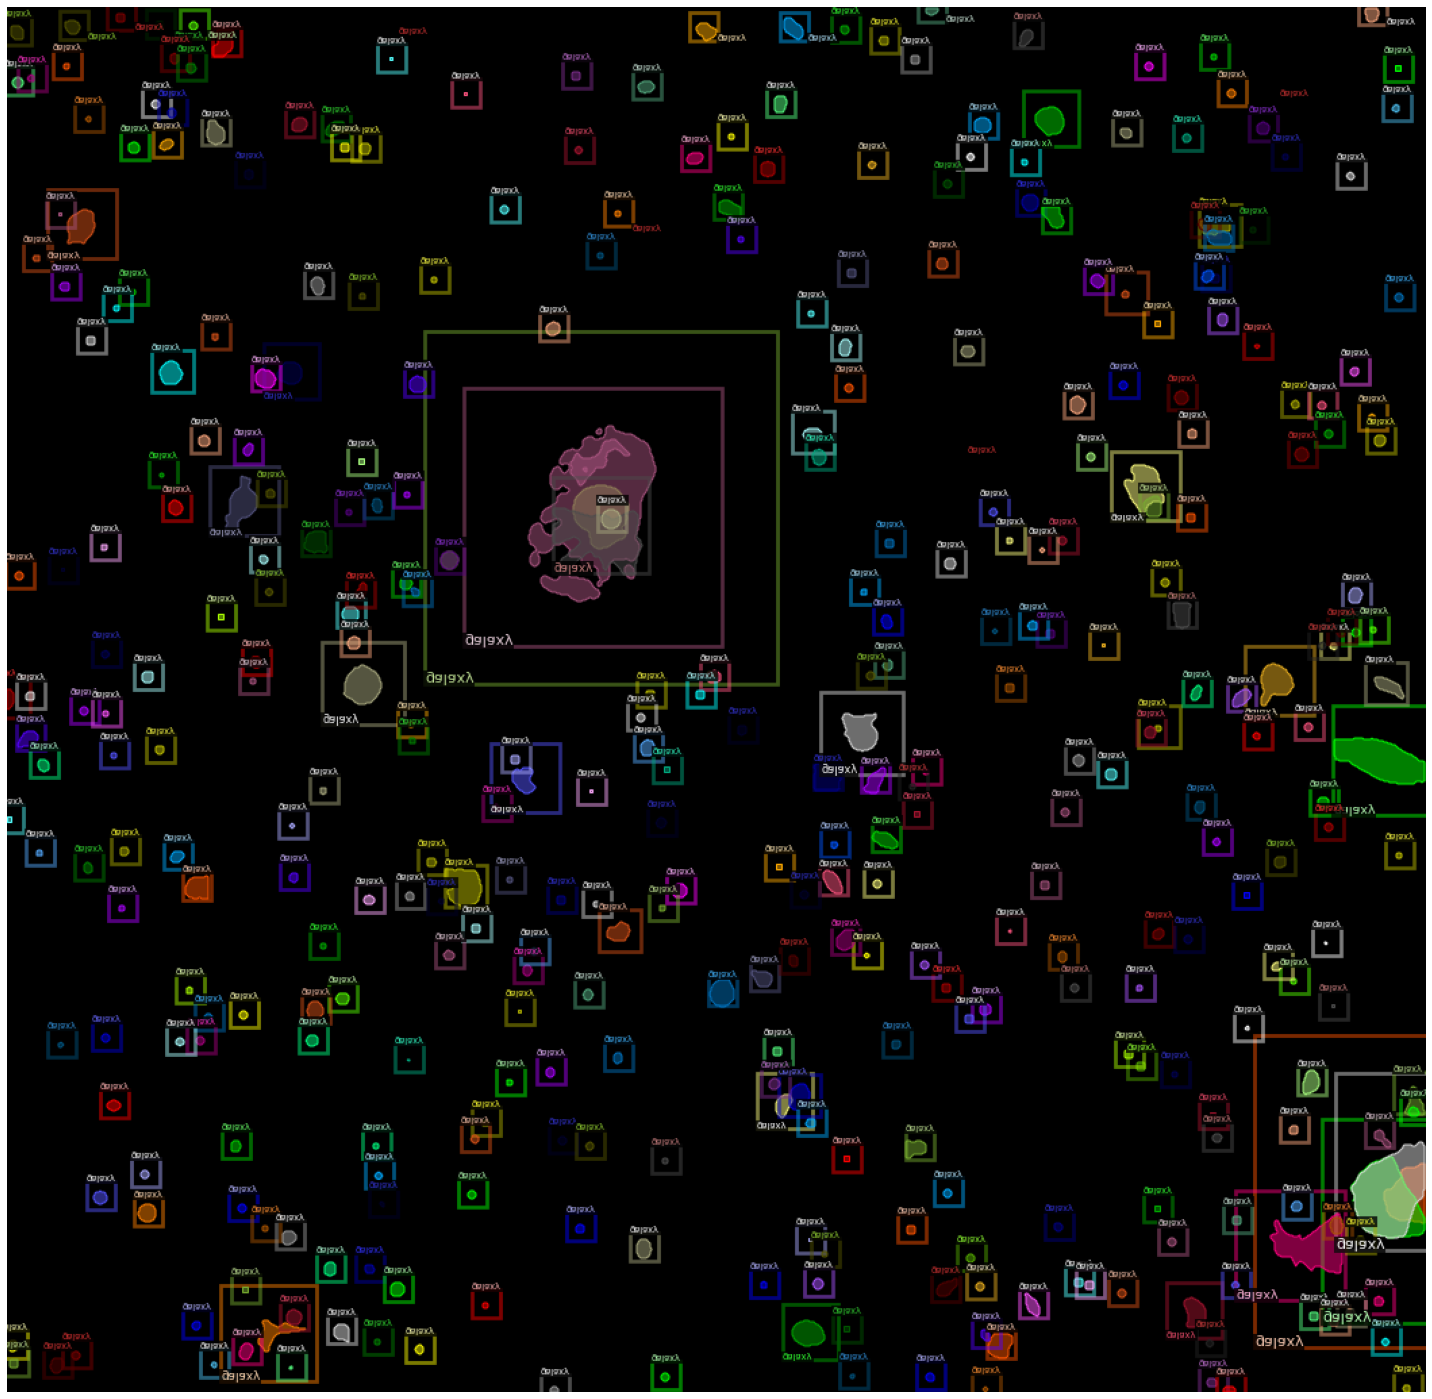

In [6]:
dataset_dicts = get_astro_dicts(filenames_dict)
nsample = 1
fig, axs = plt.subplots(1, nsample, figsize=(20*nsample, 20))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d, normalize="lupton", stretch=0.5, Q=10)
    visualizer = Visualizer(img/65000*255, metadata=astro_train_metadata)
    out = visualizer.draw_dataset_dict(d)
    axs.imshow(out.get_image(), origin='lower')
    axs.axis('off')
    fig.tight_layout()
    fig.show()
print(img.dtype)

In [12]:
dataset_dicts[0].keys()

dict_keys(['filename_G', 'filename_R', 'filename_I', 'image_id', 'height', 'width', 'annotations'])

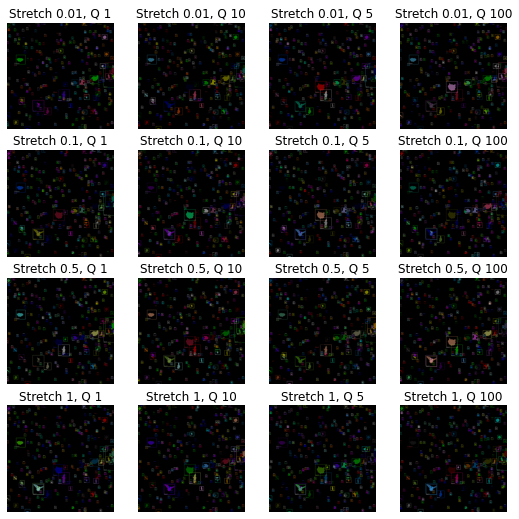

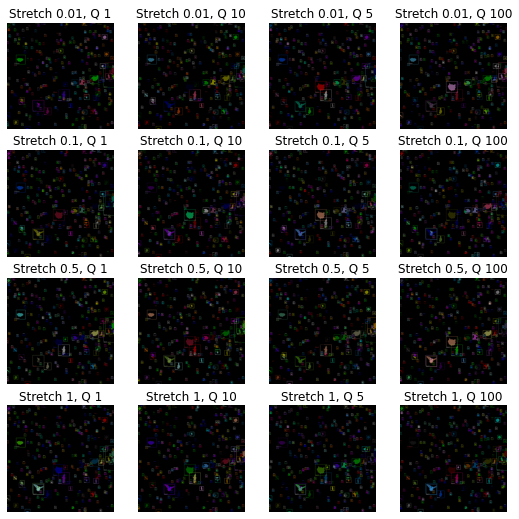

In [7]:
plot_stretch_Q(dataset_dicts,astro_train_metadata, 0)

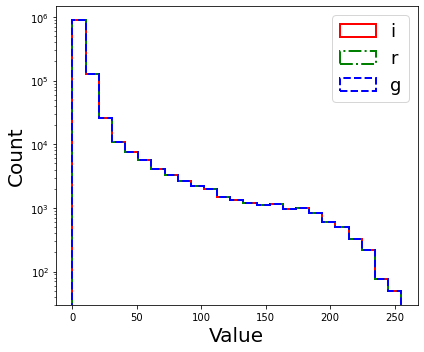

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1, label='i');
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2, label='r');
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3, label='g');
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)

ax.legend(fontsize=18)

fig.tight_layout()

### Training

#### Data Augmentation

In [7]:

def train_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = read_image(dataset_dict, **read_image_args)
    augs = T.AugmentationList([
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

#### Visualize Augmented Data

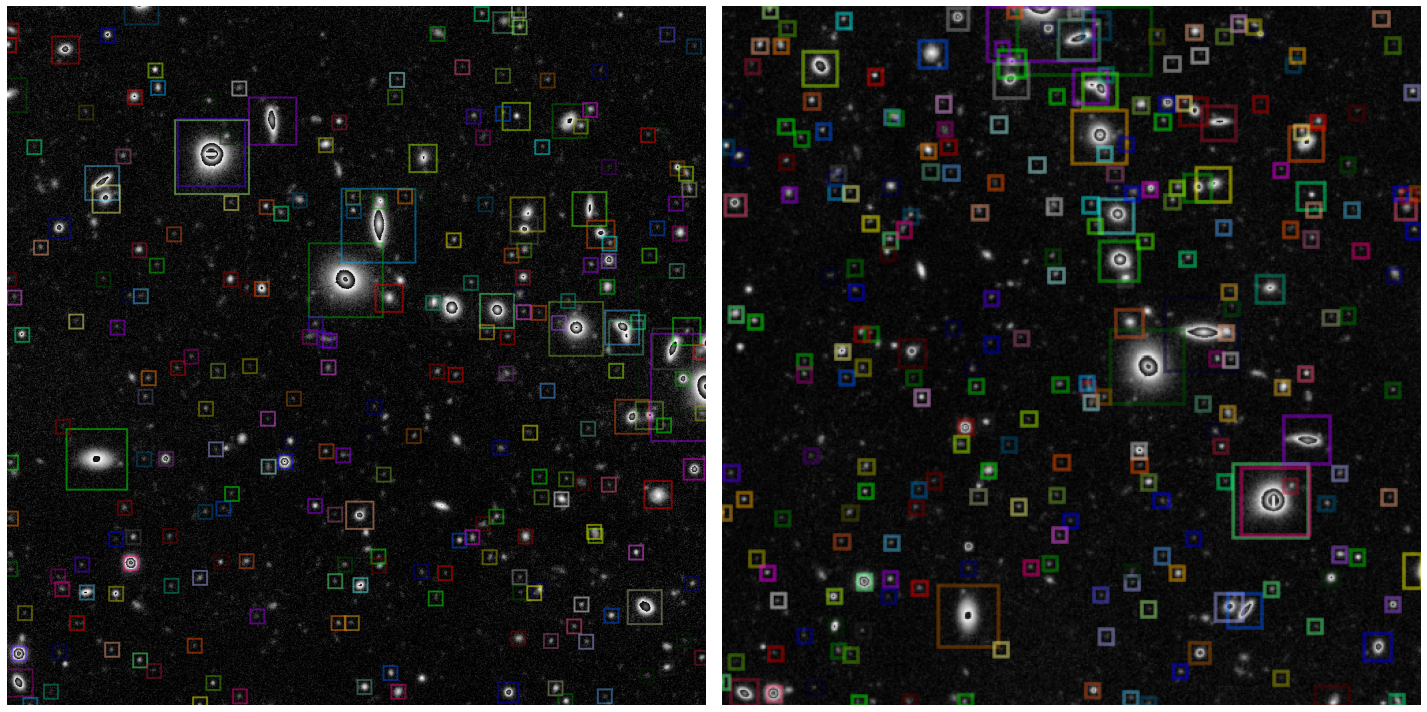

In [8]:
from detectron2.structures import BoxMode
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

dictionary = iter(dataset_dicts)
d = next(dictionary)
img = read_image(d, normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
visualizer = Visualizer(img, metadata=astro_train_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d, normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_train_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

In [9]:
init_coco_weights = True # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_test") # Register Metadata
cfg.DATASETS.TEST = ("astro_test") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'model_temp.pth')  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001   # pick a good LR -- start from 0.005
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100    # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = './output'
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = toolkit.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)
print(type(optimizer))

[01/08 22:32:59 d2.data.build]: Removed 0 images with no usable annotations. 57 images left.
[01/08 22:32:59 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 0            |   galaxy   | 16264        |
|            |              |            |              |
|   total    | 16264        |            |              |
[01/08 22:32:59 d2.data.build]: Using training sampler TrainingSampler
[01/08 22:32:59 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[01/08 22:32:59 d2.data.common]: Serialized dataset takes 3.06 MiB
<class 'torch.optim.sgd.SGD'>


In [10]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(50) # print loss every 10 iterations
trainer.train(0,200)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[01/08 22:32:59 d2.engine.train_loop]: Starting training from iteration 0


/home/yufengl2/.conda/envs/colin1/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


Iteration:  50  time:  3.259629011154175e-07  loss:  tensor(1.7123, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  100  time:  2.7008354663848877e-07  loss:  tensor(1.7452, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  150  time:  6.761401891708374e-07  loss:  tensor(1.7500, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  200  time:  2.3655593395233154e-07  loss:  tensor(1.6242, device='cuda:0', grad_fn=<AddBackward0>)


In [1]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

Reusing TensorBoard on port 6007 (pid 124445), started 0:02:01 ago. (Use '!kill 124445' to kill it.)

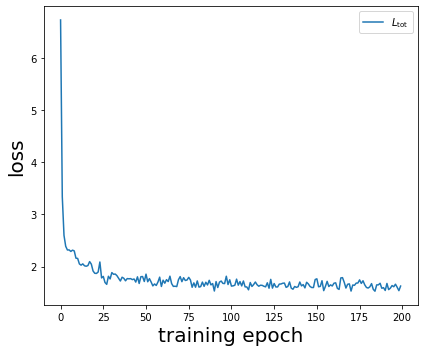

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r'$L_{\rm{tot}}$')
ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

### Inference

In [11]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

total instances: 313
detected instances: 159

total instances: 358
detected instances: 139

total instances: 322
detected instances: 171



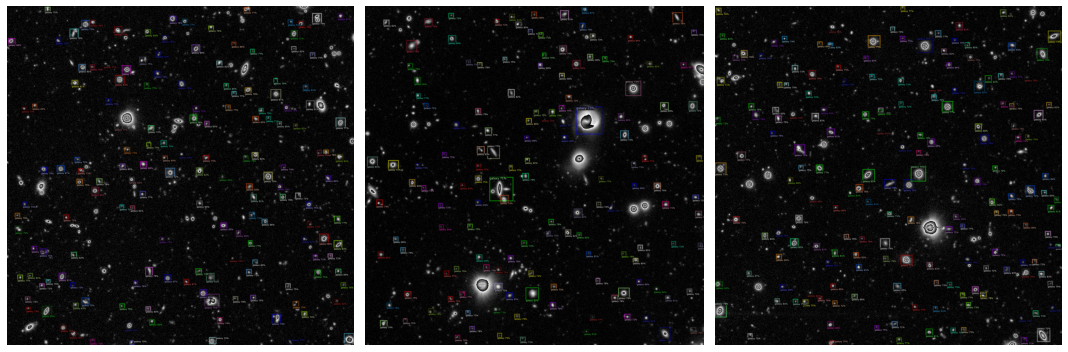

In [13]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts, nsample)):
    img = read_image(d, normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    print('total instances:', len(d['annotations']))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    
    v = Visualizer(img,
                   metadata=astro_train_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [14]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict, *read_image_args)
    augs = T.AugmentationList([
        #T.RandomRotation([-90, 90, 180], sample_style='choice'),
        #T.RandomFlip(prob=0.5),
        #T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos
    }

In [15]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_train", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

# First run with train_mapper to generate .json files consistent with training format
# Then run with test_mapper to get AP scores (doesn't work with augmentation mapper)
train_loader = build_detection_test_loader(dataset_dicts, mapper=train_mapper)
test_loader = build_detection_test_loader(dataset_dicts, mapper=test_mapper)

[01/08 22:38:15 d2.evaluation.coco_evaluation]: 'astro_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [01/08 22:38:15 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/astro_train_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/08 22:38:15 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[01/08 22:38:16 d2.data.common]: Serialized dataset takes 3.06 MiB
[01/08 22:38:16 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[01/08 22:38:16 d2.data.common]: Serialized dataset takes 3.06 MiB


In [16]:
#Yufeng jan8 bug shown below
results = inference_on_dataset(predictor.model, train_loader, evaluator)

[01/08 22:38:28 d2.evaluation.evaluator]: Start inference on 57 images
[01/08 22:38:34 d2.evaluation.evaluator]: Inference done 11/57. 0.1532 s / img. ETA=0:00:22
[01/08 22:38:39 d2.evaluation.evaluator]: Inference done 21/57. 0.1533 s / img. ETA=0:00:18
[01/08 22:38:45 d2.evaluation.evaluator]: Inference done 31/57. 0.1534 s / img. ETA=0:00:13
[01/08 22:38:50 d2.evaluation.evaluator]: Inference done 41/57. 0.1536 s / img. ETA=0:00:08
[01/08 22:38:56 d2.evaluation.evaluator]: Inference done 51/57. 0.1534 s / img. ETA=0:00:03
[01/08 22:38:59 d2.evaluation.evaluator]: Total inference time: 0:00:28.021374 (0.538873 s / img per device, on 1 devices)
[01/08 22:38:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.153422 s / img per device, on 1 devices)
[01/08 22:38:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/08 22:38:59 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/08 22:38:59 d2.evaluatio

NameError: name 'precision_star' is not defined

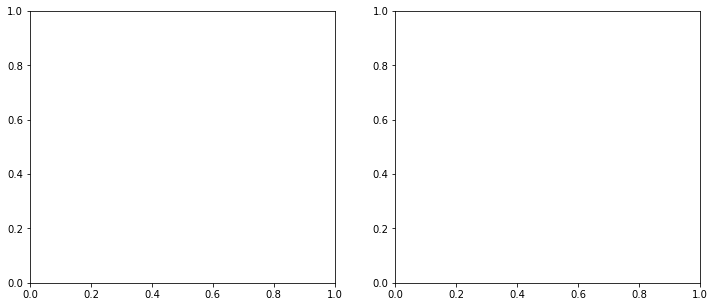

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate([precision_star, precision_galaxy]):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        # What are the IoU levels?
        p = precision_class[i, :, j, 0, -1]
        r = np.linspace(0, 1, precision_shape[1]) # i think
        mask = (p > -1)
        p = p[mask]
        r = r[mask]
        # Plot
        iou = np.around(ious[i], 2)
        axs[j].plot(r, p, label=f'{iou}', color=colors[i],lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].legend(fontsize=10)
        
fig.tight_layout()

In [ ]:
BBOX